/tmp/ipykernel_55/1546665068.py:18: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/kaggle/input/india-air-quality-data/data.csv", encoding="latin1")


Total NO2 samples: 419509
a_r = 2.0
b_r = 0.3
Epoch 0 | D loss: 1.3883501291275024 | G loss: 0.7090071439743042
Epoch 500 | D loss: 1.3847378492355347 | G loss: 0.705668568611145
Epoch 1000 | D loss: 1.3923454284667969 | G loss: 0.6706600785255432
Epoch 1500 | D loss: 1.3970258235931396 | G loss: 0.677830159664154
Epoch 2000 | D loss: 1.393216848373413 | G loss: 0.6795244216918945
Epoch 2500 | D loss: 1.3762412071228027 | G loss: 0.6818253993988037
Epoch 3000 | D loss: 1.3855141401290894 | G loss: 0.6917672753334045


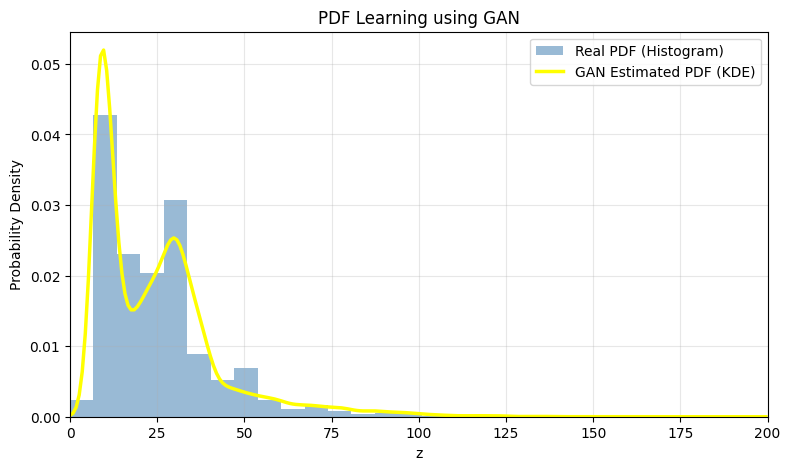

In [1]:

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
from google.colab import files






df = pd.read_csv("/kaggle/input/india-air-quality-data/data.csv", encoding="latin1")

x = df["no2"].dropna().values.reshape(-1, 1)
print("Total NO2 samples:", len(x))


r = 102303800
a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

print("a_r =", a_r)
print("b_r =", b_r)


z = x + a_r * np.sin(b_r * x)


scaler = StandardScaler()
z_scaled = scaler.fit_transform(z)
z_tensor = torch.tensor(z_scaled, dtype=torch.float32)


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


G = Generator()
D = Discriminator()

criterion = nn.BCELoss()

opt_G = optim.Adam(G.parameters(), lr=0.0005)
opt_D = optim.Adam(D.parameters(), lr=0.0007)


epochs = 3001
batch_size = 128

for epoch in range(epochs):
    idx = np.random.randint(0, z_tensor.size(0), batch_size)
    real = z_tensor[idx]

    noise = torch.randn(batch_size, 1)
    fake = G(noise)

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    loss_D = criterion(D(real), real_labels) + criterion(D(fake.detach()), fake_labels)
    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()

    loss_D = criterion(D(real), real_labels) + criterion(D(fake.detach()), fake_labels)
    opt_D.zero_grad()
    loss_D.backward()
    opt_D.step()

    loss_G = criterion(D(fake), real_labels)
    opt_G.zero_grad()
    loss_G.backward()
    opt_G.step()

    if epoch % 500 == 0:
        print("Epoch", epoch, "| D loss:", loss_D.item(), "| G loss:", loss_G.item())


with torch.no_grad():
    z_fake = G(torch.randn(20000, 1)).numpy()


z_fake = scaler.inverse_transform(z_fake)
z_real = scaler.inverse_transform(z_tensor.numpy())


kde_fake = gaussian_kde(z_fake.flatten())

z_vals = np.linspace(
    min(z_real.min(), z_fake.min()),
    max(z_real.max(), z_fake.max()),
    1000
)

z_vals = z_vals[z_vals < 200]


plt.figure(figsize=(9, 5))

plt.hist(
    z_real.flatten(),
    bins=130,
    density=True,
    alpha=0.55,
    color="steelblue",
    label="Real PDF (Histogram)"
)

plt.plot(
    z_vals,
    kde_fake(z_vals),
    color="yellow",
    linewidth=2.5,
    label="GAN Estimated PDF (KDE)"
)

plt.xlabel("z")
plt.ylabel("Probability Density")
plt.title("PDF Learning using GAN")
plt.legend()
plt.grid(alpha=0.3)

plt.xlim(0, 200)
plt.ylim(0, None)

plt.show()